# Weather Trend Forecasting – Exploratory Data Analysis

**PM Accelerator** | Data Science Assessment

---

This notebook performs comprehensive EDA on the Global Weather Repository dataset, including:
1. Data loading & inspection
2. Missing value analysis
3. Temperature & precipitation distributions
4. Time-series visualisations for major cities
5. Correlation heatmap
6. Anomaly detection (STL + Isolation Forest)
7. Spatial temperature map
8. Monthly climate comparison by continent

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
%matplotlib inline

from src.cleaning import run_cleaning, CLEAN_PATH
from src.anomalies import stl_anomaly_detection, isolation_forest_anomalies

## 1 – Load Cleaned Data

In [2]:
if CLEAN_PATH.exists():
    df = pd.read_parquet(CLEAN_PATH)
else:
    df = run_cleaning()

print(f'Shape: {df.shape}')
df.head()

Shape: (125058, 47)


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,moonrise,moonset,moon_phase,moon_illumination,date,temperature_celsius_outlier,humidity_outlier,precip_mm_outlier,wind_kph_outlier,pressure_mb_outlier
0,United States of America,Washington Park,46.60,-120.49,America/Los_Angeles,1715868900,2024-05-16 07:15:00,15.6,60.1,Sunny,...,01:36 PM,02:52 AM,Waxing Gibbous,55,2024-05-16,False,False,False,True,False
1,El Salvador,San Salvador,13.71,-89.20,America/El_Salvador,1715868000,2024-05-16 08:00:00,26.0,78.8,Partly cloudy,...,01:00 PM,01:02 AM,Waxing Gibbous,55,2024-05-16,False,False,True,False,False
2,Costa Rica,San Juan,9.97,-84.08,America/Costa_Rica,1715868000,2024-05-16 08:00:00,23.0,73.4,Sunny,...,12:42 PM,12:37 AM,Waxing Gibbous,55,2024-05-16,False,False,False,False,False
3,Belize,Belmopan,17.25,-88.77,America/Belize,1715868000,2024-05-16 08:00:00,30.0,86.0,Partly cloudy,...,12:56 PM,01:04 AM,Waxing Gibbous,55,2024-05-16,False,False,False,False,False
4,Mexico,Mexico City,19.43,-99.13,America/Mexico_City,1715868000,2024-05-16 08:00:00,13.0,55.4,Sunny,...,01:37 PM,01:49 AM,Waxing Gibbous,55,2024-05-16,False,False,False,False,False


In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 125058 entries, 0 to 125057
Data columns (total 47 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   country                       125058 non-null  str           
 1   location_name                 125058 non-null  str           
 2   latitude                      125058 non-null  float64       
 3   longitude                     125058 non-null  float64       
 4   timezone                      125058 non-null  str           
 5   last_updated_epoch            125058 non-null  int64         
 6   last_updated                  125058 non-null  datetime64[ns]
 7   temperature_celsius           125058 non-null  float64       
 8   temperature_fahrenheit        125058 non-null  float64       
 9   condition_text                125058 non-null  str           
 10  wind_mph                      125058 non-null  float64       
 11  wind_kph                

In [4]:
df.describe()

,latitude,longitude,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,wind_mph,wind_kph,wind_degree,pressure_mb,...,air_quality_carbon_monoxide,air_quality_ozone,air_quality_nitrogen_dioxide,air_quality_sulphur_dioxide,air_quality_pm2_5,air_quality_pm10,air_quality_us_epa_index,air_quality_gb_defra_index,moon_illumination,date
count,125058.000000,125058.000000,1.250580e+05,125058,125058.000000,125058.000000,125058.000000,125058.000000,125058.000000,125058.000000,...,125058.000000,125058.000000,125058.000000,125058.000000,125058.000000,125058.000000,125058.00000,125058.000000,125058.000000,125058
mean,19.204517,21.993234,1.743780e+09,2025-04-04 17:27:23.379072,21.580072,70.845888,8.066862,12.985931,169.207152,1014.053767,...,475.924476,58.890110,15.254783,10.671481,24.597570,49.232237,1.71015,2.634274,49.392618,2025-04-04 05:54:30.105071360
min,-41.300000,-175.200000,1.715849e+09,2024-05-16 07:15:00,-29.800000,-21.600000,2.200000,3.600000,1.000000,947.000000,...,-9999.000000,0.000000,0.000000,-9999.000000,0.168000,-1848.150000,1.00000,1.000000,0.000000,2024-05-16 00:00:00
25%,3.870000,-6.836100,1.729934e+09,2024-10-26 10:15:00,16.300000,61.300000,3.800000,6.100000,80.000000,1010.000000,...,210.900000,39.000000,1.665000,1.050000,7.150000,10.050000,1.00000,1.000000,15.000000,2024-10-26 00:00:00
50%,17.250000,23.240000,1.743844e+09,2025-04-05 05:00:00,24.100000,75.400000,6.900000,11.200000,162.000000,1014.000000,...,303.400000,56.000000,5.500000,2.450000,14.250000,20.300000,1.00000,2.000000,49.000000,2025-04-05 00:00:00
75%,40.400000,50.405550,1.757665e+09,2025-09-12 11:15:00,28.100000,82.600000,11.000000,17.600000,256.000000,1018.000000,...,473.600000,75.000000,17.760000,8.600000,28.120000,42.180000,2.00000,3.000000,84.000000,2025-09-12 00:00:00
max,64.150000,179.220000,1.771571e+09,2026-02-20 20:00:00,49.200000,120.600000,1841.200000,2963.200000,360.000000,3006.000000,...,38879.398000,480.700000,427.700000,521.330000,1614.100000,6037.290000,6.00000,10.000000,100.000000,2026-02-20 00:00:00
std,24.418946,65.731665,1.605904e+07,NaN,9.610087,17.298023,7.366713,11.852505,103.465734,10.607361,...,781.663382,31.085138,24.252712,36.926244,37.811732,151.864953,0.95047,2.472562,35.130227,NaN


## 2 – Missing Values

In [5]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    missing.plot.bar(ax=ax, color='salmon')
    ax.set_title('Missing Values per Column')
    ax.set_ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print('No missing values!')

No missing values!


## 3 – Temperature & Precipitation Distributions

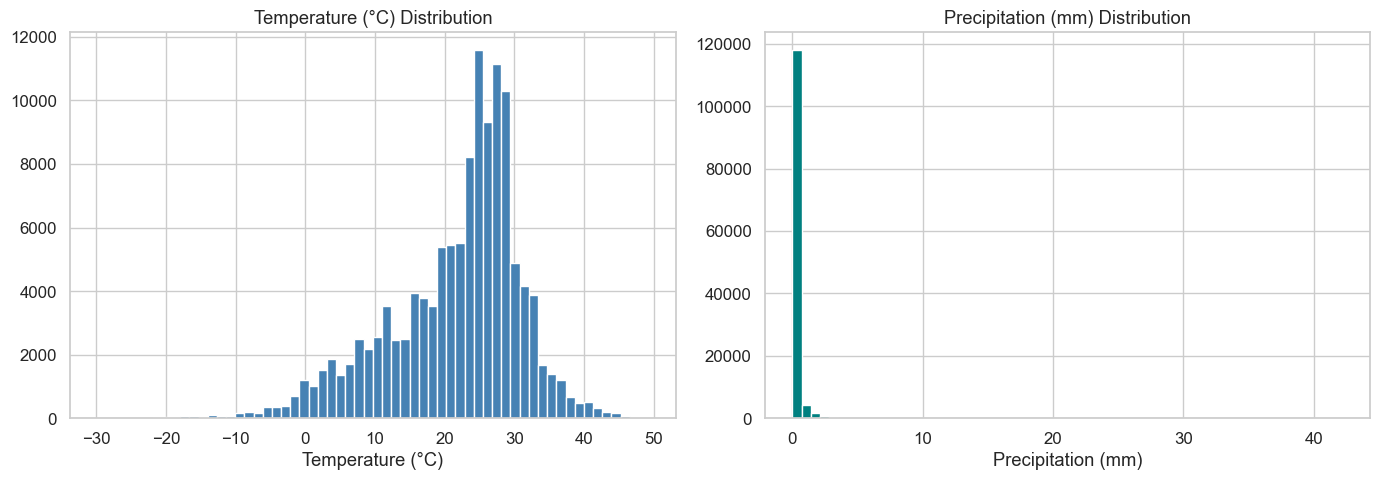

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df['temperature_celsius'].dropna().hist(bins=60, ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Temperature (°C) Distribution')
axes[0].set_xlabel('Temperature (°C)')

df['precip_mm'].dropna().hist(bins=60, ax=axes[1], color='teal', edgecolor='white')
axes[1].set_title('Precipitation (mm) Distribution')
axes[1].set_xlabel('Precipitation (mm)')
plt.tight_layout()
plt.show()

## 4 – Time Series for Major Cities

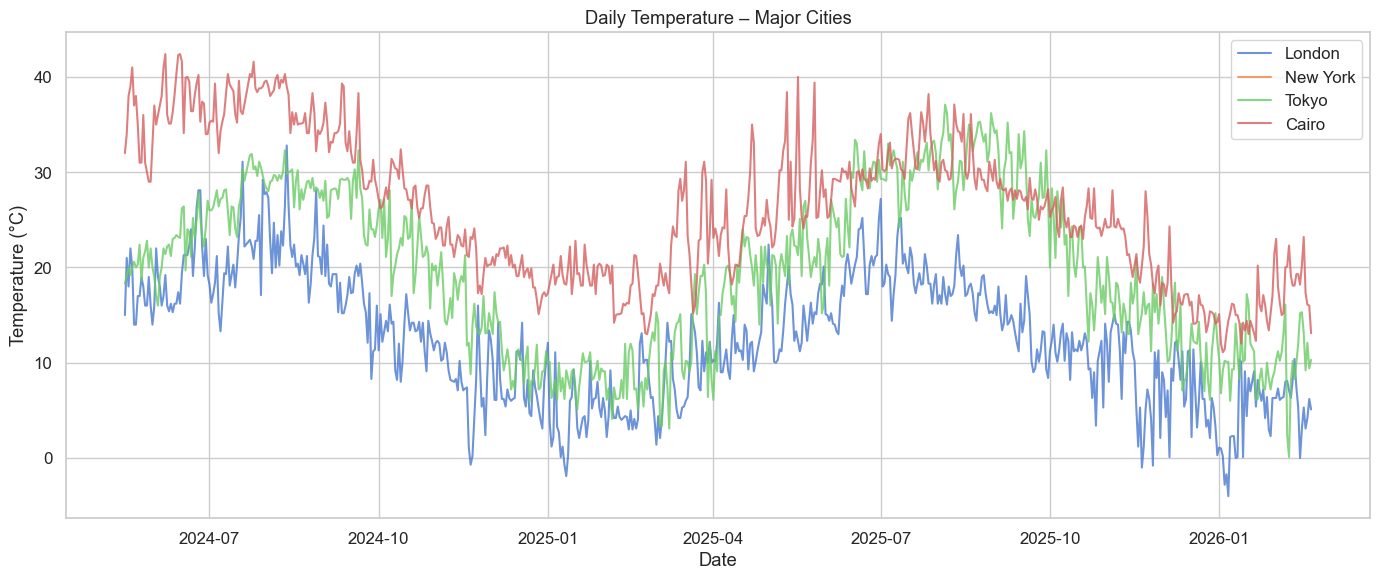

In [7]:
MAJOR_CITIES = ['London', 'New York', 'Tokyo', 'Sydney', 'Cairo']

fig, ax = plt.subplots(figsize=(14, 6))
for city in MAJOR_CITIES:
    sub = df[df['location_name'] == city].sort_values('date')
    if len(sub) == 0:
        continue
    ax.plot(sub['date'], sub['temperature_celsius'], label=city, alpha=0.8)
ax.set_title('Daily Temperature – Major Cities')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.legend()
plt.tight_layout()
plt.show()

## 5 – Correlation Heatmap

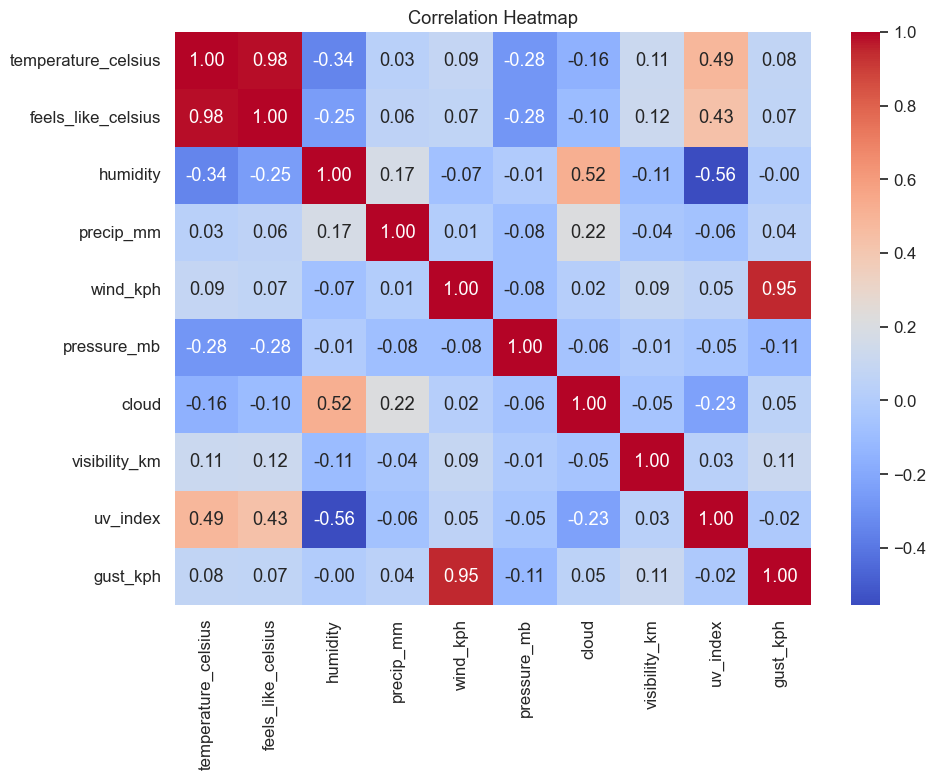

In [8]:
numeric = df.select_dtypes(include='number')
keep_cols = [
    'temperature_celsius', 'feels_like_celsius', 'humidity',
    'precip_mm', 'wind_kph', 'pressure_mb', 'cloud',
    'visibility_km', 'uv_index', 'gust_kph',
]
keep_cols = [c for c in keep_cols if c in numeric.columns]
corr = numeric[keep_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
ax.set_title('Correlation Heatmap')
plt.tight_layout()
plt.show()

## 6 – STL Anomaly Detection

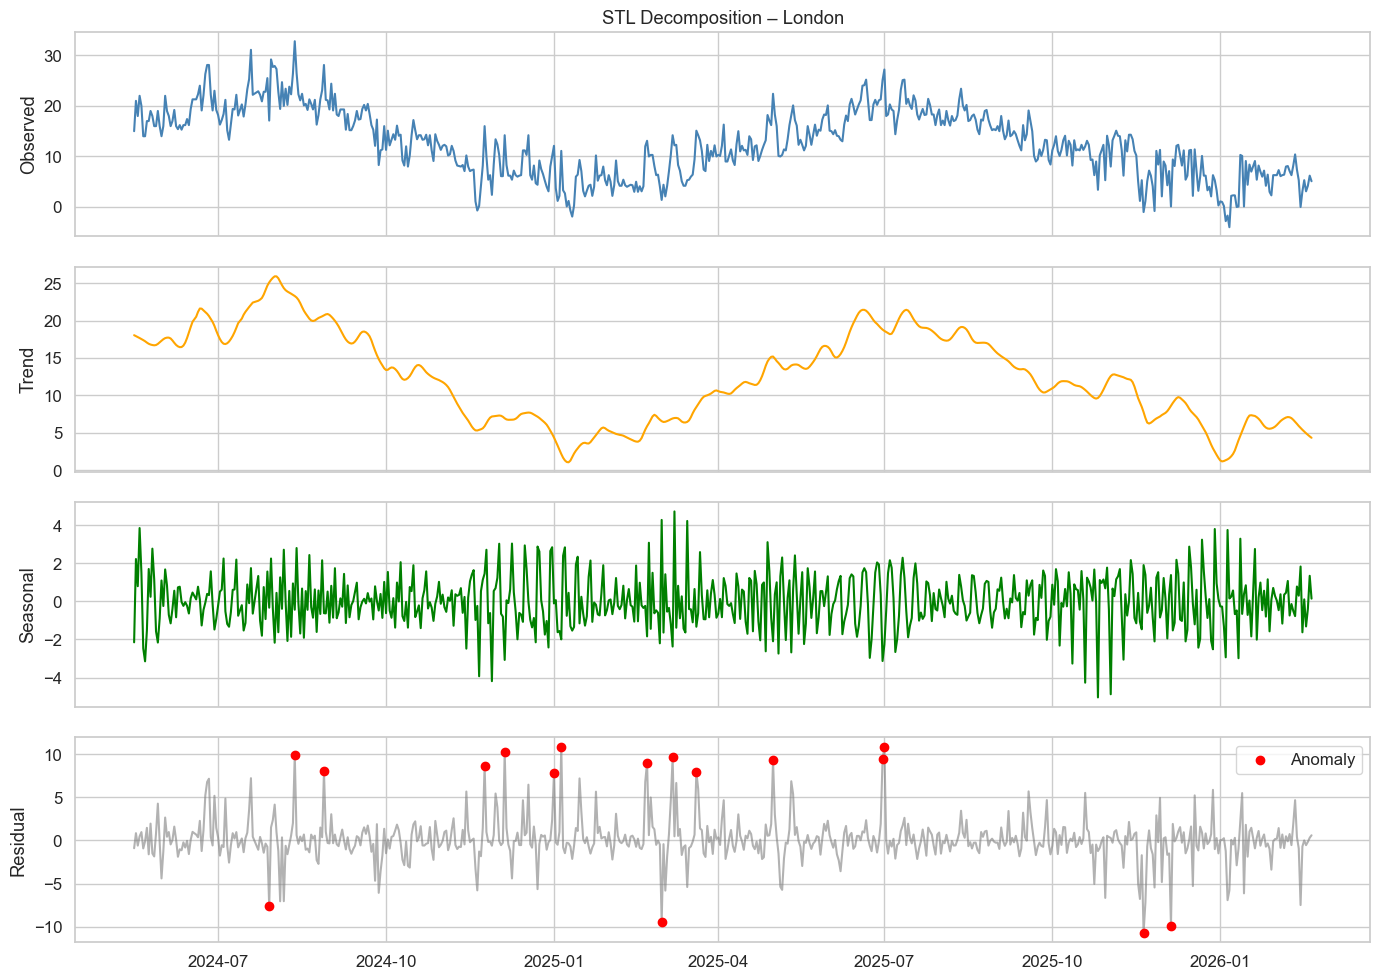

STL anomalies detected: 16


In [9]:
city = 'London'
sub = df[df['location_name'] == city].sort_values('date').set_index('date')
ts = sub['temperature_celsius'].dropna()

stl_df = stl_anomaly_detection(ts, period=7)

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
axes[0].plot(ts.index, ts.values, color='steelblue')
axes[0].set_ylabel('Observed')
axes[0].set_title(f'STL Decomposition – {city}')
axes[1].plot(stl_df.index, stl_df['trend'], color='orange')
axes[1].set_ylabel('Trend')
axes[2].plot(stl_df.index, stl_df['seasonal'], color='green')
axes[2].set_ylabel('Seasonal')
axes[3].plot(stl_df.index, stl_df['resid'], color='grey', alpha=0.6)
anom_idx = stl_df[stl_df['anomaly']].index
axes[3].scatter(anom_idx, stl_df.loc[anom_idx, 'resid'], color='red', zorder=5, label='Anomaly')
axes[3].set_ylabel('Residual')
axes[3].legend()
plt.tight_layout()
plt.show()

print(f'STL anomalies detected: {stl_df["anomaly"].sum()}')

## 7 – Isolation Forest Anomalies

In [10]:
df['iso_forest_anomaly'] = isolation_forest_anomalies(df)
n_anom = df['iso_forest_anomaly'].sum()
print(f'Isolation Forest anomalies: {n_anom} / {len(df)} ({100*n_anom/len(df):.2f}%)')

Isolation Forest anomalies: 2502 / 125058 (2.00%)


## 8 – Spatial Temperature Map

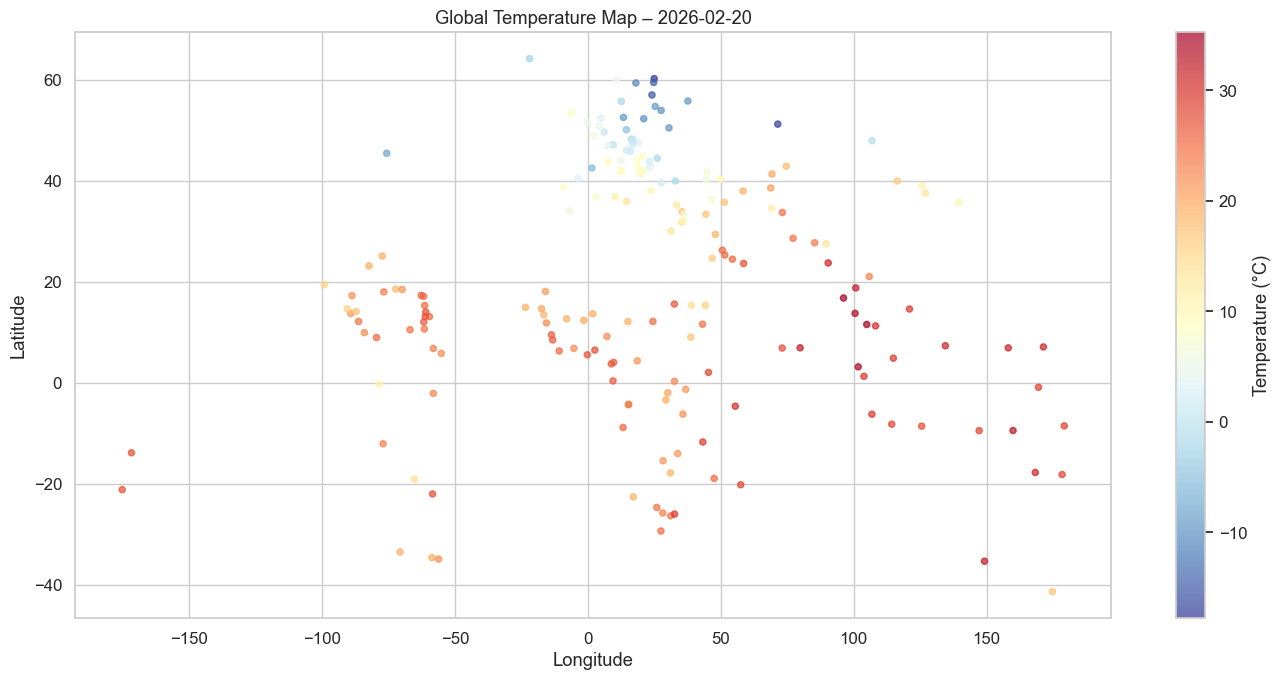

In [11]:
latest_date = df['date'].max()
snap = df[df['date'] == latest_date].drop_duplicates('location_name')

fig, ax = plt.subplots(figsize=(14, 7))
sc = ax.scatter(
    snap['longitude'], snap['latitude'],
    c=snap['temperature_celsius'], cmap='RdYlBu_r',
    s=20, alpha=0.7
)
plt.colorbar(sc, ax=ax, label='Temperature (°C)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Global Temperature Map – {latest_date.date()}')
plt.tight_layout()
plt.show()

## 9 – Monthly Climate Comparison by Continent

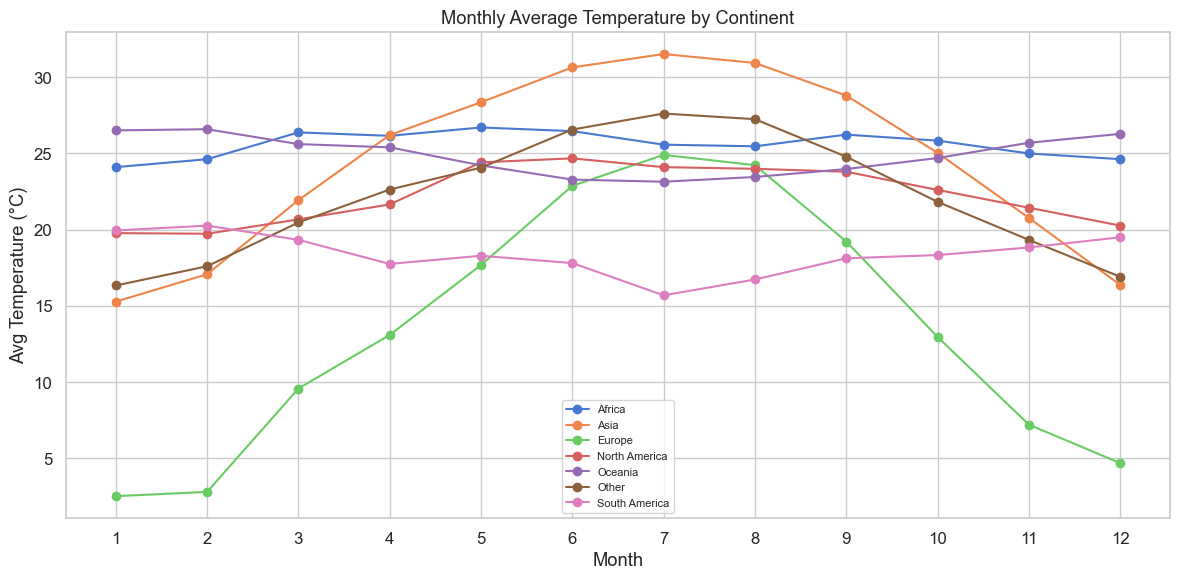

In [12]:
# Lightweight continent mapping
from src.utils import country_to_continent
continent_map = country_to_continent()
df['continent'] = df['country'].map(continent_map).fillna('Other')
df['month_num'] = df['date'].dt.month

monthly = df.groupby(['continent', 'month_num'])['temperature_celsius'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
for cont in monthly['continent'].unique():
    c = monthly[monthly['continent'] == cont]
    ax.plot(c['month_num'], c['temperature_celsius'], marker='o', label=cont)
ax.set_xlabel('Month')
ax.set_ylabel('Avg Temperature (°C)')
ax.set_title('Monthly Average Temperature by Continent')
ax.set_xticks(range(1, 13))
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

## 10 – Air Quality vs Weather Correlation

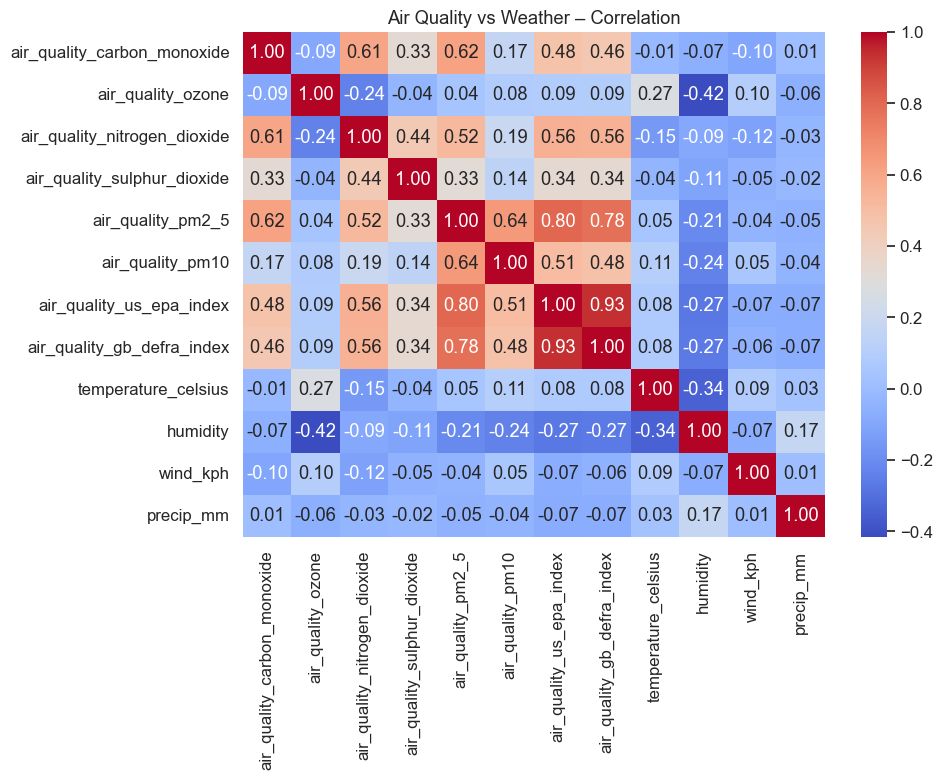

In [13]:
aq_cols = [c for c in df.columns if c.startswith('air_quality')]
weather_cols = ['temperature_celsius', 'humidity', 'wind_kph', 'precip_mm']
combined = [c for c in aq_cols + weather_cols if c in df.columns]

corr = df[combined].corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
ax.set_title('Air Quality vs Weather – Correlation')
plt.tight_layout()
plt.show()